# Homework 2 - Programming

There are two main tasks in this programming assignment are to implement the **eight-point algorithm** and **four-point algorithm**. 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils

## Remarks before starting
Please take note of the following few things:

1. In your `hw2_progrmming` folder, there are two subfolders, namely `four_point` and `eight_point`. In each folder, there are four pairs of scenes (8 images in total) and a `numpy` file, which contains the numpy array of coordinate correspondences. Each image has dimensions (512, 512). For eight-point algorithm, you have 10 points for each pair of scene. For four-point algorithm, you have 6 points for each pair of scene. 
2. coordinate correspondences are given to you as a numpy array, with dimensions (4, 2, 10, 2) for eight-point and (4, 2, 6, 2) for four-point. The dimensions correspond to `(num_scenes, camera angle, num_pts, pixel_coordinates)`. I highly encourage you to print out the array to get a better sense of the x, y, and z axis. 
3. To transform pixel coordinates to Euclidean system, you will need the intrinsic matrix. In our synthetic dataset, the intrinsic matrix `K` is the same for all scenes and camera angles. 
4. Some helpful functions are implemented in `utils.py`. I encourage you to take a look before starting. 

In [2]:
K = np.array([[ 560   ,  0.    ,  0.        ],  # intrinsic matrix
              [ 0.    ,  560   ,  0.        ],
              [ 0.    ,  0.    ,  1.        ]])

## Eight Point Algorithm

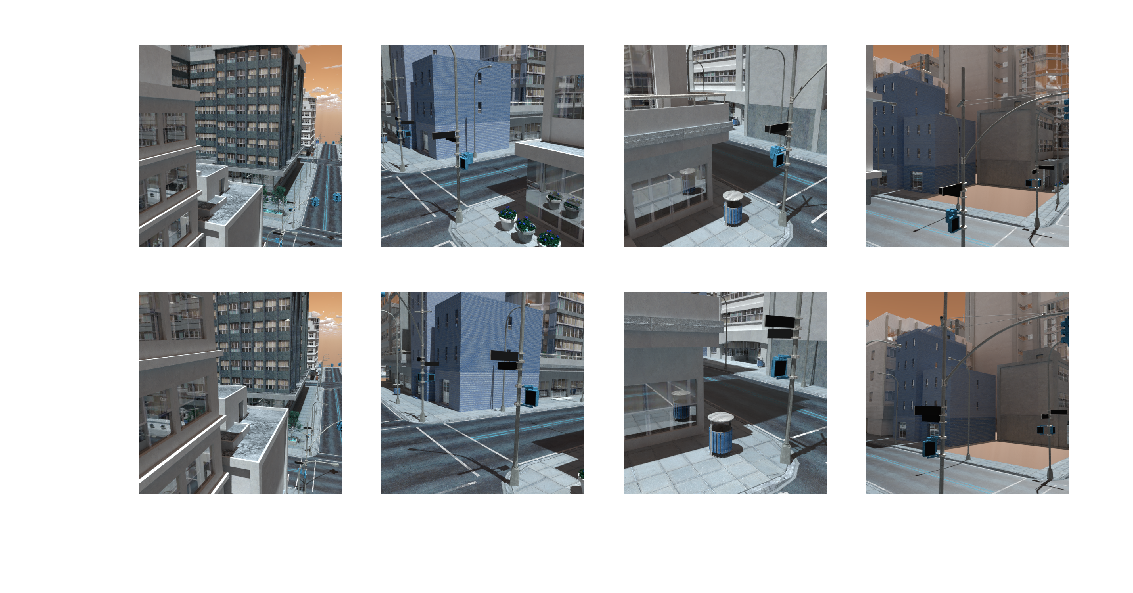

In [3]:
# data loading
folder = "./eight_point/"
img_arr = utils.load_scenes(folder)
utils.plot_scenes(img_arr)

In [4]:
# read correspondences
corr = np.load(os.path.join(folder, 'eight_pt_corr.npy'))

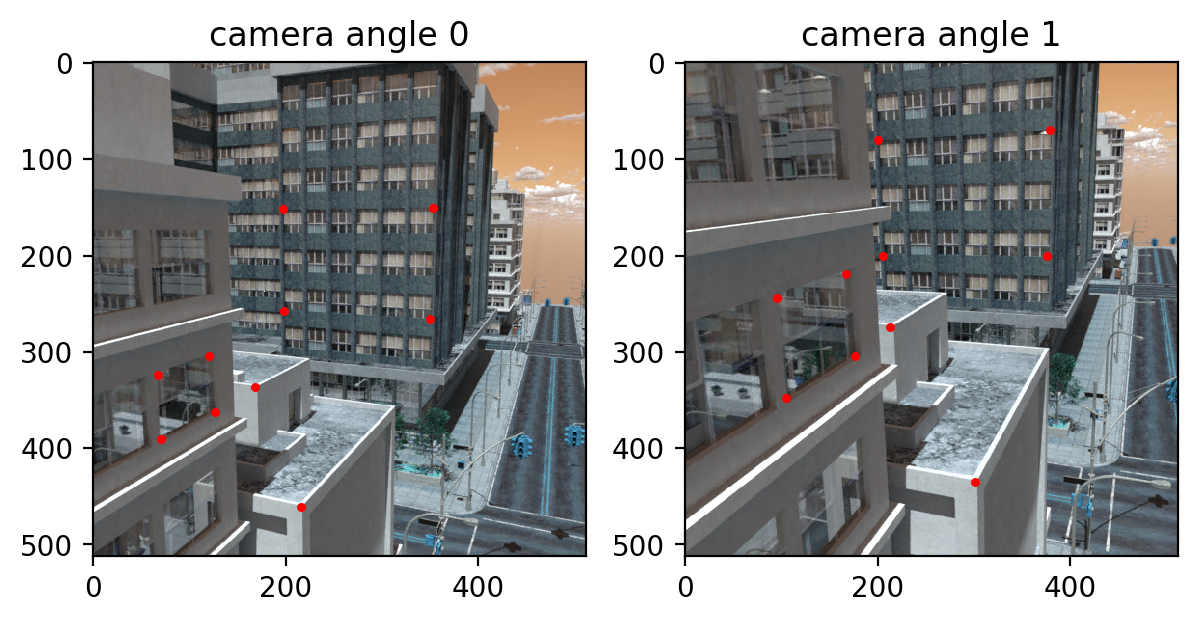

In [5]:
scene_id = 0 # change this to view other scenes
utils.plot_correspondences(img_arr, corr, scene_id)

**TASK1**: Implement the eight-point algorithm below. 

## Helper Functionality


In [6]:
def is_normal(A):
    vec = inverse_hat(A)
    return np.allclose(np.linalg.norm(vec), 1, atol=1e-4)

In [7]:
def is_antisymettric(A):
    return np.allclose(A.T, -1 * A, atol=1e-4)

In [8]:
def is_rotation_matrix(A):
    #TODO: edit the functionality for this
    return np.allclose(np.linalg.det(A), 1, atol=1e-5) \
       and np.allclose(A.T @ A, np.identity(3), atol=1e-4)

In [9]:
def hat(point):
    assert point.shape == (3,1) or point.shape == (3,)
    x, y, z = point[0], point[1], point[2]
    return np.array([[0     ,     -1 * z,            y],
                     [z     ,          0,       -1 * x],
                     [-1 * y,          x,            0]])


In [10]:
def inverse_hat(hat_matrix):
    assert hat_matrix.shape == (3,3)
    x, y, z = hat_matrix[2,1], hat_matrix[0,2], hat_matrix[1,0]
    return np.array([[x,y,z]]).T

In [11]:
def R_z(theta):   
    return np.array([[np.cos(theta), -1 * np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta)     , 0],
                     [0            ,0                  ,1]])



In [12]:
def kronecker_product(X_1, X_2):
    _, D_1 = X_1.shape
    _, D_2 = X_2.shape
    
    A = np.zeros((1, D_1 * D_2))
    for i in range(D_1):
        A[:, i * D_2 : (i + 1) * D_2] = X_1[:, i] * X_2                   
    return A    

In [13]:
def homogenous_representation(corr):
    num_scenes, camera, num_pts, pixel_coords = corr.shape
    lift = np.ones((num_scenes, camera, num_pts, 1))
    return np.concatenate((corr, lift), axis = 3)

In [14]:
def euclidean_coordinates(corr):
    homogenous_coordinates = homogenous_representation(corr)
    num_scenes, cameras, num_pts, pixel_coords = homogenous_coordinates.shape
    euclidean_coordinates = np.zeros_like(homogenous_coordinates)
    for scene in range(num_scenes):
        for camera in range(cameras):
            euclidean_coordinates[scene, camera] = (K @ homogenous_coordinates[scene, camera].T).T
    return euclidean_coordinates

In [15]:
def stacked_matrix(corr):
    euclidean_coords = euclidean_coordinates(corr)  
    camera_one, camera_two = euclidean_coords[:,0], euclidean_coords[:, 1]
    num_scenes, num_pts, coords = camera_one.shape
    stacked_corr = np.zeros((num_scenes, num_pts, coords ** 2))
    for scene in range(num_scenes):
        for pt in range(num_pts):
            pt_1, pt_2 = camera_one[scene, pt].reshape((1,-1)), camera_two[scene, pt].reshape((1,-1))
            stacked_corr[scene, pt] = kronecker_product(pt_1, pt_2)
            
    return stacked_corr

In [16]:
def unstack(stacked):
    assert stacked.shape == (9,1) or (9,)
    unstacked = stacked.reshape((3,3))
    return unstacked

In [17]:
def stack(unstacked):
    stacked = unstacked.reshape((9,1))
    return stacked;

In [18]:
def first_order_matrix(X):
    U, S, V_T = np.linalg.svd(X, full_matrices=True)
    V = V_T.T
    first_order_approx = unstack(V[:,-1])
    return first_order_approx

In [19]:
def structure_reconstruction(R, T_hat, points):
    #credit to 5.2.2 in the textbook, ideally it should be the case that all the positive depth constraints are satisfied
    camera_one, camera_two = points[0], points[1]
    N, _ = camera_one.shape
    M, T = np.zeros(((3 * N), N + 1)), inverse_hat(T_hat)
    for i in range(N):
        M_j, lambda_j = (hat(camera_two[i]) @ R @ camera_one[i]), (hat(camera_two[i]) @ T).reshape((-1))
        M[i:i+3, i], M[i:i+3, -1] = M_j, lambda_j
    
    eigen_vals, eigen_vecs = np.linalg.eig(M.T @ M)
    depth_estimate = eigen_vecs[:,-1]
    pos_depth_estimate = np.where(depth_estimate > 0, 1, 0)
    return(np.sum(pos_depth_estimate))

In [143]:
def impose_positive_depth_homography(camera_one, camera_two, H):
    num_pts, _ = camera_one.shape
    
    is_H, is_neg_H = 0, 0
    for i in range(num_pts):
        if camera_two[i].T @ H @ camera_one[i] > 0:
            is_H += 1
        if camera_two[i].T @ (-1 * H) @ camera_one[i] > 0:
            is_neg_H += 1
    if is_H > is_neg_H:
        return H
    return (-1 * H)
    

In [196]:
def candidate_homographies(H, V, S):
    sigma_1, sigma_2, sigma_3 = S[0], S[1], S[2]
    
    v_1, v_2, v_3 = V[:,0], V[:,1], V[:,2]
    u_1 = ((np.sqrt(1 - sigma_3 ** 2) * v_1) + (np.sqrt(sigma_1 ** 2 - 1) * v_3)) / np.sqrt(sigma_1 ** 2 - sigma_3 ** 2)
    u_2 = ((np.sqrt(1 - sigma_3 ** 2) * v_1) - (np.sqrt(sigma_1 ** 2 - 1) * v_3)) / np.sqrt(sigma_1 ** 2 - sigma_3 ** 2)
    
    U_1 = np.concatenate((v_2.reshape((-1,1)), u_1.reshape((-1,1)), np.matmul(hat(v_2),u_1).reshape((-1,1))), axis=1)
    U_2 = np.concatenate((v_2.reshape((-1,1)), u_2.reshape((-1,1)), np.matmul(hat(v_2),u_2).reshape((-1,1))), axis=1)
    
    W_1 = np.concatenate((np.matmul(H, v_2).reshape((-1,1)), \
                          np.matmul(H, u_1).reshape((-1,1)), \
                          np.matmul(hat(np.matmul(H, v_2)), np.matmul(H, u_1)).reshape((-1,1))), axis=1)
    
    W_2 = np.concatenate((np.matmul(H, v_2).reshape((-1,1)), \
                          np.matmul(H, u_2).reshape((-1,1)), \
                          np.matmul(hat(np.matmul(H, v_2)), np.matmul(H, u_2)).reshape((-1,1))), axis=1)
    
    R_1 = W_1 @ U_1.T
    N_1 = hat(v_2) @ u_1
    T_1 = (H - R_1) @ N_1
    S1 = R_1, N_1, T_1
    
    R_2 = W_2 @ U_2.T
    N_2 = hat(v_2) @ u_2
    T_2 = (H - R_2) @ N_2
    S2 = R_2, N_2, T_2
    
    S3 = R_2, -1 * N_1, -1 * T_2
    S4 = R_2, -1 * N_2, -1 * T_2
    
    return S1, S2, S3, S4
    

In [197]:
def eight_point_algorithm(corr, scene=0):
    #compute the first order essential matrix
    R = None
    T = None   
    X = stacked_matrix(corr)[scene]
    E = first_order_matrix(X)
    U, S, V_T = np.linalg.svd(E, full_matrices=True)
    
    #project onto the essential space
    proj_S = np.diagflat([1,1,0])
    E_proj = U @ proj_S @ V_T
    
    #select the set (R, T) that complies with the positive depth constraint
    
    #chose from the four solutions
    R_1, T_1 = U @ R_z(np.pi / 2).T @ V_T, U @ R_z(np.pi / 2).T @ proj_S @U.T
    R_2, T_2 = U @ R_z(-1 * np.pi / 2).T @ V_T, U @ R_z(np.pi / 2).T @ proj_S @ U.T
    R_3, T_3 = U @ R_z(np.pi / 2).T @ V_T, U @ R_z(-1 * np.pi / 2).T @ proj_S @ U.T
    R_4, T_4 = U @ R_z(-1 * np.pi / 2).T @ V_T, U @ R_z(-1 * np.pi / 2).T @ proj_S @ U.T

    
    #chose the one that satisfies the greatest number of positive depth requirements
    potential_solutions = [(R_1, T_1), (R_2, T_2), (R_3, T_3), (R_4, T_4)]
    pos_depth = []
    for R_prime,T_prime in potential_solutions:
        points = euclidean_coordinates(corr)[scene]
        pos_depth.append(structure_reconstruction(R_prime, T_prime, points))   
    best = np.argmax(pos_depth)
    R, T = potential_solutions[best][0], potential_solutions[best][1]
    return R, T

## Some Sanity Checks 

In [198]:
R, T = eight_point_algorithm(corr)
print("verifying T is antisymettric:", is_antisymettric(T))
print("verifying T is normalized:", is_normal(T))
print("verifying R is a rotation matrix:", is_rotation_matrix(R))



verifying T is antisymettric: True
verifying T is normalized: True
verifying R is a rotation matrix: True


## Four-point Algorithm

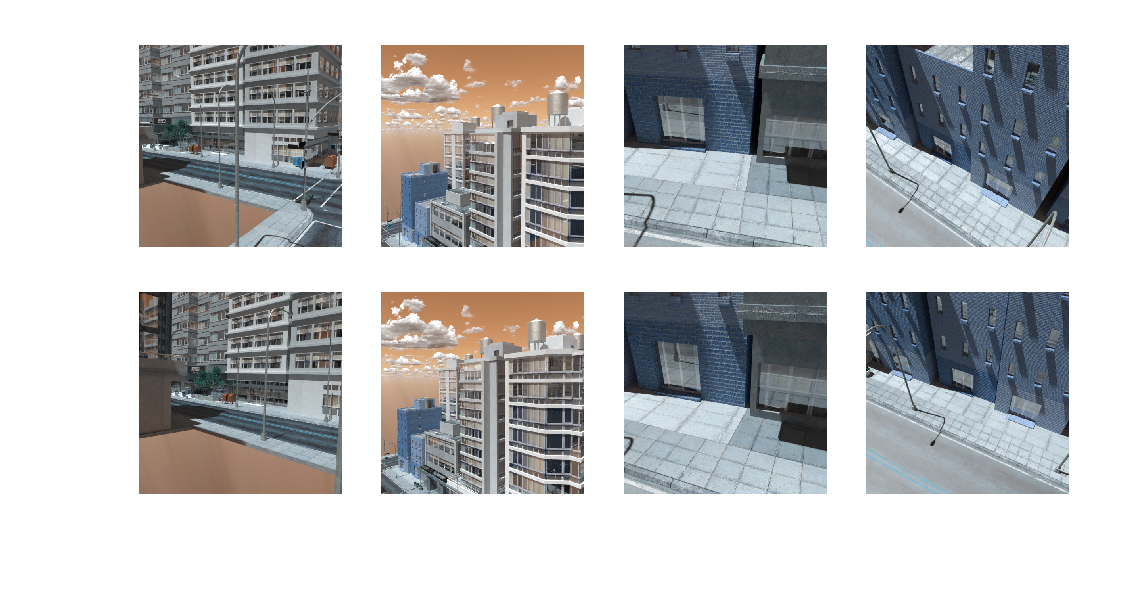

In [199]:
# data loading
folder = "./four_point/"
img_arr = utils.load_scenes(folder)
utils.plot_scenes(img_arr)

In [200]:
# read correspondences
corr = np.load(os.path.join(folder,'four_pt_corr.npy'))

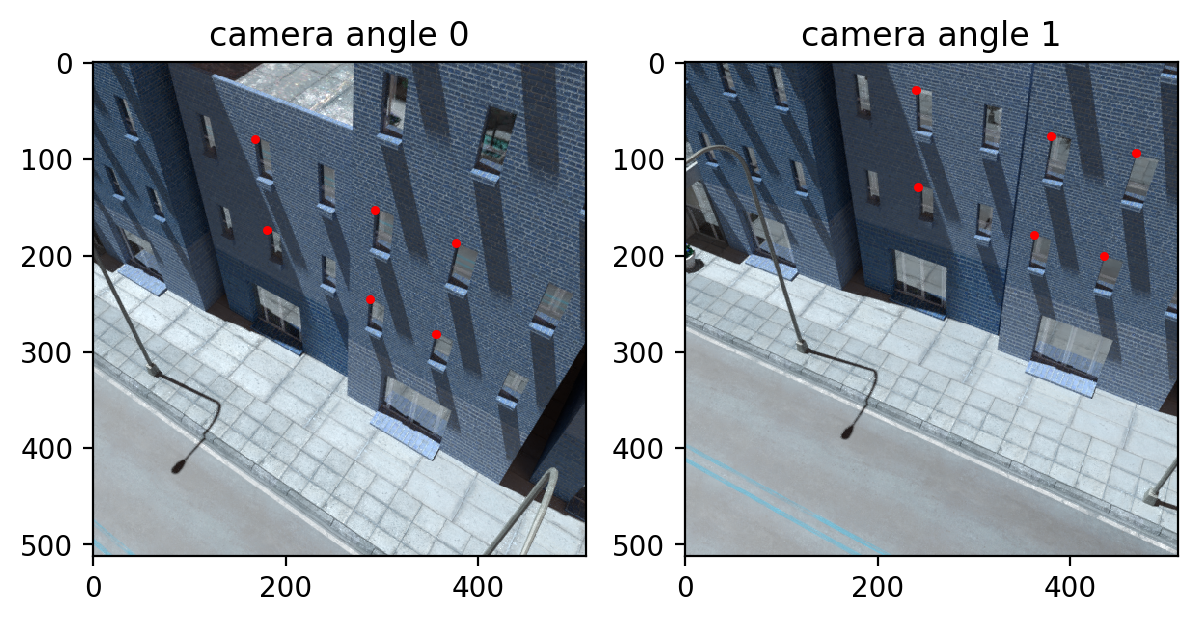

In [201]:
# plotting correspondences
scene_id = 3
utils.plot_correspondences(img_arr, corr, scene_id)

**TASK2**: Implement the four-point algorithm below

In [219]:
def four_point_algorithm(corr, scene=0):
    R = None
    N = None
    T = None
    ####compute the first approximation of the homography matrix
    X = stacked_matrix(corr)[scene]
    H_l = first_order_matrix(X)
    U, S, V_T = np.linalg.svd(H_l, full_matrices=True)
    
    ###Normalize the first order approximation using the second singular value
    sigma_2 = S[1]
    H = H_l / sigma_2
    ###correct the sign by enforcing the positive depth constraint
    camera_one = euclidean_coordinates(corr)[scene][0]
    camera_two = euclidean_coordinates(corr)[scene][1]
    H = impose_positive_depth_homography(camera_one, camera_two, H)
    
    ####Decompose the homography matrix
    V, S, V_T = np.linalg.svd(H.T @ H, full_matrices=True)
    
    #compute the candidate homography decompositions s_i = (R_i, N_i, T_i)
    s1, s2, s3, s4 = candidate_homographies(H, V, S)
    
    for soln in candidate_homographies(H, V, S):
        R_c, N_c, T_c = soln
        #verify the positive depth constraint requirment is satisfied
        #return any solution that satisfies this requirement
        if N_c.T @ np.array([0,0,1]) > 0:
            R, N, T = R_c, N_c, T_c
            break;
    
    return R, N, T

In [221]:
R, N, T = four_point_algorithm(corr)

End of Assignment